In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys                                                                              
np.random.seed(1)                                                                       
import tensorflow as tf                                                                 
tf.random.set_seed(2)
from tensorflow.keras.models import Sequential, load_model                              
from tensorflow.keras.layers import Dense, LSTM , Dropout, BatchNormalization                                     
from tensorflow.keras.optimizers import Adam,RMSprop                                             
from tensorflow.keras.callbacks import EarlyStopping                                   
from sklearn.preprocessing import MinMaxScaler                                          
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error  
from math import sqrt
from keras import optimizers
import datetime as dt
from datetime import date,datetime
import time
plt.style.use('ggplot')                                                                 

c:\Users\LAP\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
#Dừng sớm qtr huấn luyện nếu 0 có cải thiện trong việc giảm thiểu mất mát trên valid
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=80,  verbose=1, mode='min')  
callbacks_list = [earlystop]                                                                          

In [3]:
data = pd.read_csv('sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)

In [4]:
def fit_model_LSTM(train, val, timesteps, hl, lr, batch, epochs):
    # np.random.seed(1)
    # tf.random.set_seed(2)

    X_train, Y_train, X_val, Y_val = [], [], [], []

    # Chuẩn bị dữ liệu cho tập train
    for i in range(timesteps, train.shape[0]):  
        X_train.append(train[i-timesteps:i])  
        Y_train.append(train[i][0])  
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Chuẩn bị dữ liệu cho tập validation
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xác định số đặc trưng
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Xây dựng model
    model = Sequential()
    model.add(LSTM(hl[0], input_shape=input_shape, activation='relu', return_sequences=True))

    for i in range(1, len(hl)-1):  
        model.add(LSTM(hl[i], activation='relu', return_sequences=True))  
        # model.add(Dropout(0.2))
    model.add(LSTM(hl[-1], activation='relu', return_sequences=False))
    model.add(Dense(1))  

    # Biên dịch mô hình
    model.compile(optimizers.Adam(learning_rate=lr), loss='mean_squared_error')

    # Thêm callback để tránh overfitting
    callbacks_list = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch, 
                        validation_data=(X_val, Y_val), verbose=1, shuffle=False,
                        callbacks=callbacks_list)

    return model, history.history['loss'], history.history['val_loss']

In [5]:
def evaluate_model(model, test, timesteps,sc):
    # np.random.seed(1)
    # tf.random.set_seed(2)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)   
    Y_test_inv = np.exp(sc.inverse_transform(np.concatenate([Y_test.reshape(-1, 1), 
                                                  np.zeros((Y_test.shape[0], test.shape[1]-1))], axis=1))[:,0])
    Y_hat_inv = np.exp(sc.inverse_transform(np.concatenate([Y_hat.reshape(-1, 1), 
                                                 np.zeros((Y_hat.shape[0], test.shape[1]-1))], axis=1))[:,0])                  
    mse = mean_squared_error(Y_test_inv, Y_hat_inv)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test_inv, Y_hat_inv)
    mae = np.mean(np.abs(Y_test_inv - Y_hat_inv))
    r2 = r2_score(Y_test_inv, Y_hat_inv)
    return mse, rmse, mape,mae, r2, Y_test_inv, Y_hat_inv

In [6]:
# Plotting the predictions: vẽ y_test và y_hat -> trực quan hoá kqua
def plot_data_LSTM(Y_test, Y_hat):
    plt.figure(figsize=(14, 6))
    plt.plot(Y_test, c = 'r')                                 #test màu đỏ
    plt.plot(Y_hat, c = 'y')                                  #dự đoán màu vàng
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using LSTM")
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()  

In [7]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.figure(figsize=(14, 6))
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

In [8]:
data.head()

,close,volume,sentiment_sector,sentiment_direct_PLX
Date,,,,
2017-04-21,35.34,4820970.0,0.0,0.571659
2017-04-22,35.34,4820970.0,0.0,0.701439
2017-04-23,35.34,4820970.0,0.0,0.096033
2017-04-24,34.98,1757390.0,0.0,0.000000
2017-04-25,32.63,2533550.0,0.0,0.497429


In [9]:
# Ngày bắt đầu và tổng số ngày
start_date = dt.date(2017, 4, 21)
end_date = dt.date(2025, 5, 5)
total_days = (end_date - start_date).days + 1  # Đếm cả ngày cuối cùng


train_days = int(total_days * 0.7)
val_days = int(total_days * 0.15)
test_days = total_days - train_days - val_days  # Phần còn lại cho test

# Xác định ngày kết thúc cho từng tập
train_end = start_date + dt.timedelta(days=train_days - 1)
val_end = train_end + dt.timedelta(days=val_days)



Mô hình LSTM

In [10]:
data['close'] = np.log(data[['close']])
# data['volume'] = np.log(data[['volume']]+1)
series = data[['close']]
# Lấy dữ liệu
train_data = series.loc[start_date:train_end]
val_data = series.loc[train_end + dt.timedelta(days=1):val_end]
test_data = series.loc[val_end + dt.timedelta(days=1):]

print(train_data.shape, val_data.shape, test_data.shape)

(2055, 1) (440, 1) (442, 1)


In [11]:
train_data.head()

,close
Date,
2017-04-21,3.565015
2017-04-22,3.565015
2017-04-23,3.565015
2017-04-24,3.554776
2017-04-25,3.485232


In [12]:

sc = MinMaxScaler() #thu nhỏ về khoảng [0,1]
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape, val.shape, test.shape)

(2055, 1) (440, 1) (442, 1)


In [13]:
# train.shape

In [14]:
timesteps = 30
hl = [40,35]      
lr = 1e-3     
batch_size = 64
num_epochs = 50

Epoch 1/50


c:\Users\LAP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2803 - val_loss: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0146 - val_loss: 0.0022
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0038 - val_loss: 0.0026
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0024 - val_loss: 9.2750e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0035 - val_loss: 7.5113e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0028 - val_loss: 8.0537e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 8.3335e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0029 - val_loss: 7.9346e-04
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0030 - val_loss: 8.8030e-04
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 8.4507e-04
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0031 - val_loss: 8.1856e-04
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 

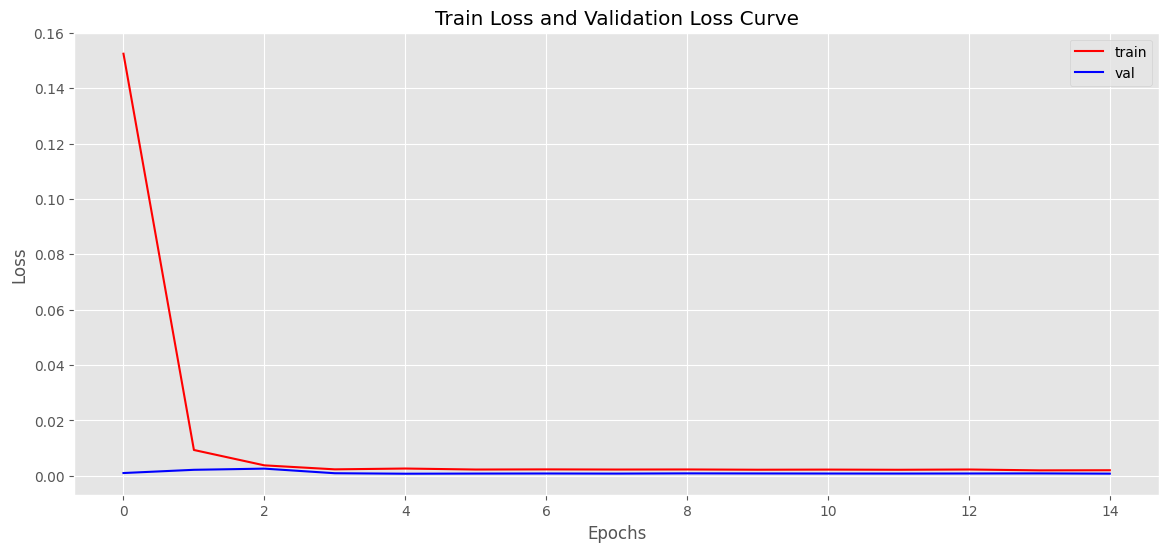

In [15]:
model, train_error, val_error = fit_model_LSTM(train, val, timesteps, hl, lr, batch_size, num_epochs)
plot_error(train_error, val_error)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
MSE = 2.6316781305458306
RMSE = 1.6222447813279692
MAPE = 0.0288521376484038
MAE = 1.188725506252241
R-Squared Score = 0.8568222271428251


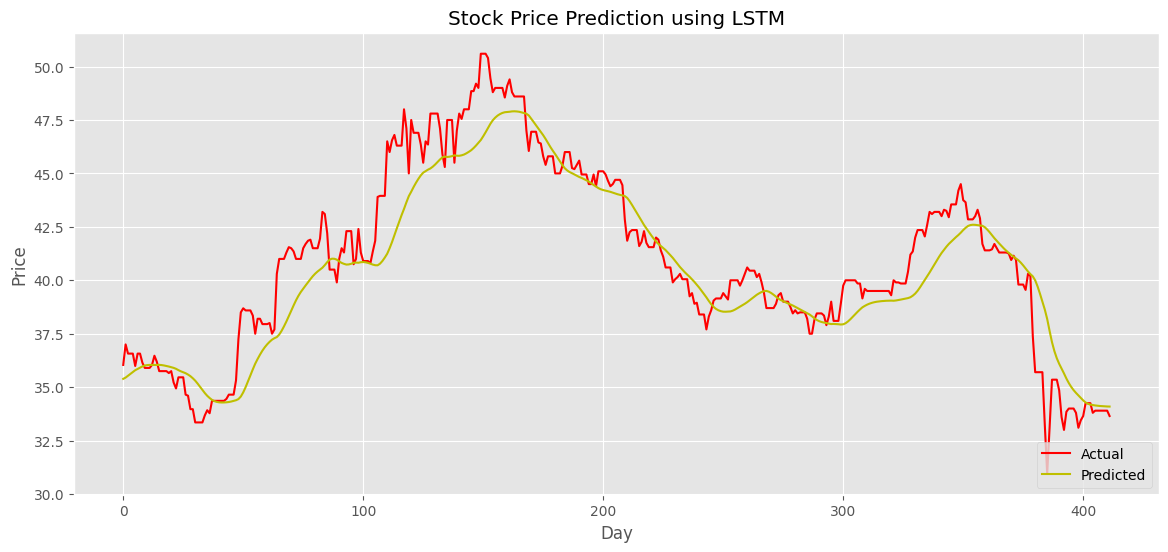

In [16]:
mse, rmse, mape, mae, r2, true, predicted = evaluate_model(model, test, timesteps,sc) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('MAE = {}'.format(mae))
print('R-Squared Score = {}'.format(r2))
plot_data_LSTM(true, predicted)


Mô hình LSTM + Sentiment Analysis

In [17]:
timesteps_1 = 30
hl_1 = [40,35]      
lr_1 = 1e-3     
batch_size_1 = 64
num_epochs_1 = 50

In [18]:

# data['sentiment_sector'] = data['sentiment_sector']
# data['sentiment_direct_PLX'] = data['sentiment_direct_PLX']
series = data[['close','sentiment_sector','sentiment_direct_PLX']]
series.fillna(0, inplace=True)
# Lấy dữ liệu
train_data_1 = series.loc[start_date:train_end]
val_data_1 = series.loc[train_end + dt.timedelta(days=1):val_end]
test_data_1 = series.loc[val_end + dt.timedelta(days=1):]

C:\Users\LAP\AppData\Local\Temp\ipykernel_716\2615686080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.fillna(0, inplace=True)


In [19]:
train_data_1

,close,sentiment_sector,sentiment_direct_PLX
Date,,,
2017-04-21,3.565015,0.000000,0.571659
2017-04-22,3.565015,0.000000,0.701439
2017-04-23,3.565015,0.000000,0.096033
2017-04-24,3.554776,0.000000,0.000000
2017-04-25,3.485232,0.000000,0.497429
...,...,...,...
2022-12-01,3.378270,0.000000,0.000000
2022-12-02,3.392493,0.000000,0.000000
2022-12-03,3.392493,0.836389,0.000000


In [20]:


sc_1 = MinMaxScaler() #thu nhỏ về khoảng [0,1]
train_1 = sc_1.fit_transform(train_data_1)
val_1 = sc_1.transform(val_data_1)
test_1 = sc_1.transform(test_data_1)
print(train_1.shape, val_1.shape, test_1.shape)

(2055, 3) (440, 3) (442, 3)


In [21]:
train_1

array([[0.37571341, 0.50159643, 0.79797973],
       [0.37571341, 0.50159643, 0.86471246],
       [0.37571341, 0.50159643, 0.55341461],
       ...,
       [0.21994824, 0.92836206, 0.50403483],
       [0.21994824, 0.76123872, 0.50403483],
       [0.23708898, 0.77653781, 0.50403483]])

Epoch 1/50


c:\Users\LAP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.2499 - val_loss: 0.0021
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0252 - val_loss: 0.0027
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0086 - val_loss: 0.0054
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0029 - val_loss: 8.3630e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0037 - val_loss: 9.0475e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0037 - val_loss: 9.0924e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.

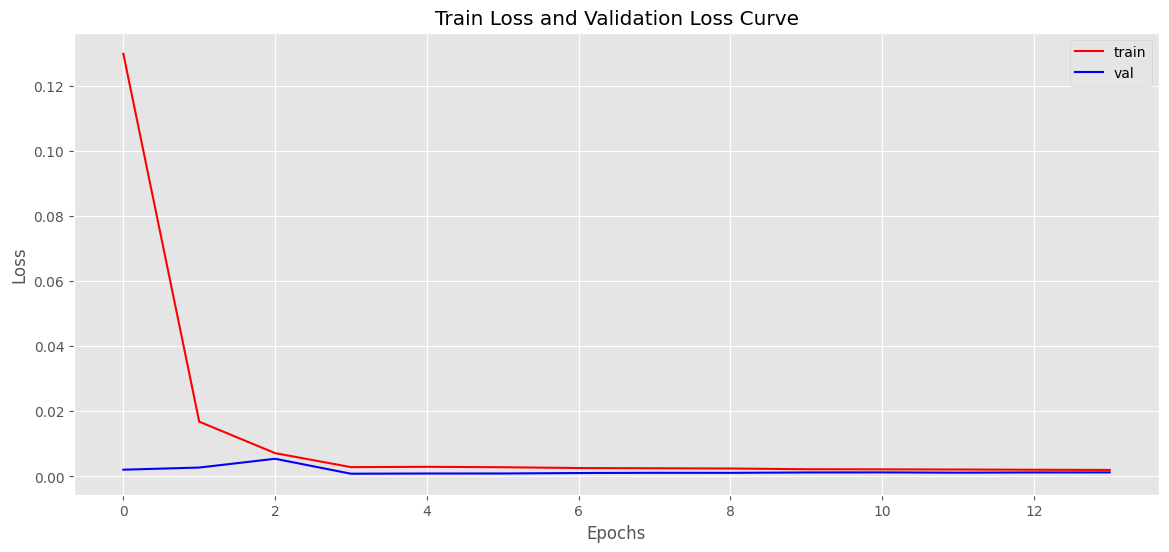

In [22]:
model_1, train_error_1, val_error_1 = fit_model_LSTM(train_1, val_1, timesteps_1, hl_1, lr_1, batch_size_1, num_epochs_1)
plot_error(train_error_1, val_error_1)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
MSE = 3.5030803788007536
RMSE = 1.8716517781897235
MAPE = 0.03362665653521633
MAE = 1.389852028165851
R-Squared Score = 0.8094131493685619


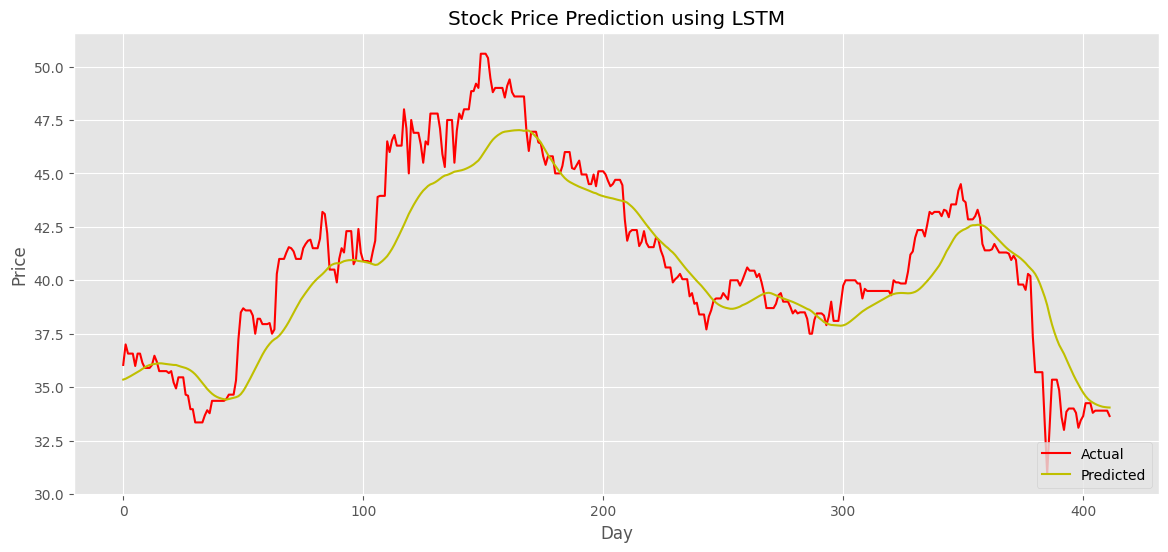

In [23]:
mse_1, rmse_1, mape_1,mae_1, r2_1, true_1, predicted_1 = evaluate_model(model_1, test_1, timesteps,sc_1) #được tính dựa trên bộ dữ liệu đã chuẩn hoá
print('MSE = {}'.format(mse_1))
print('RMSE = {}'.format(rmse_1))
print('MAPE = {}'.format(mape_1))
print('MAE = {}'.format(mae_1))
print('R-Squared Score = {}'.format(r2_1))
plot_data_LSTM(true_1, predicted_1)


Mô hình TimesNet

In [24]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


c:\Users\LAP\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [25]:

seq_len = 30
pred_len = 1
# Tải dữ liệu và tiền xử lý
data = pd.read_csv('sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data = data[['close']]
data['close'] = np.log(data['close'])
# data['volume'] = np.log(data['volume'] + 1)  
data.fillna(0, inplace=True) 

In [26]:
data.head()

,close
Date,
2017-04-21,3.565015
2017-04-22,3.565015
2017-04-23,3.565015
2017-04-24,3.554776
2017-04-25,3.485232


In [27]:
#Chuẩn hóa dữ liệu đầu vào
scaler = MinMaxScaler()
data[['close']] = scaler.fit_transform(data[['close']])
# Chia dữ liệu thành tập huấn luyện, tập xác thực và tập kiểm tra
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size + val_size]
test = data.iloc[train_size + val_size:]

In [28]:
#Hàm tạo sequence
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data.iloc[i:i+seq_len].values)  
        y.append(data.iloc[i+seq_len:i+seq_len+pred_len, 0])  
    return np.array(X), np.array(y)
# Tạo sequences cho các tập train, val, test
X_train, y_train = create_sequences(train, seq_len, pred_len)
X_val, y_val = create_sequences(val, seq_len, pred_len)
X_test, y_test = create_sequences(test, seq_len, pred_len)
# Convert dữ liệu sang tensor và thêm chiều cuối cho phù hợp với output model
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# In ra kích thước của các tập dữ liệu
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: torch.Size([2025, 30, 1]), torch.Size([2025, 1, 1])
Val: torch.Size([410, 30, 1]), torch.Size([410, 1, 1])
Test: torch.Size([412, 30, 1]), torch.Size([412, 1, 1])


In [29]:
# Mô hình TimesNet
import torch
import torch.nn as nn

class TimesBlock(nn.Module):
    def __init__(self, in_channels, kernel_size, dilation_base, dropout):
        super(TimesBlock, self).__init__()
        padding = ((kernel_size - 1) * dilation_base) // 2
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size,
                               padding=padding, dilation=dilation_base)
        self.norm = nn.LayerNorm(in_channels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):  
        residual = x
        x = x.permute(0, 2, 1)  
        out = self.conv1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = out.permute(0, 2, 1)  
        out = self.norm(out + residual)
        return out


class TimesNet(nn.Module):
    def __init__(self, config):
        super(TimesNet, self).__init__()

        self.input_dim = config["input_dim"]               
        self.hidden_dim = config["hidden_dim"]             
        self.pred_len = config["pred_len"]                 
        self.output_dim = config["output_dim"]             
        self.n_blocks = config["n_blocks"]                 
        self.kernel_size = config["kernel_size"]           
        self.dropout = config.get("dropout", 0.2)          

        self.input_proj = nn.Linear(self.input_dim, self.hidden_dim)
        self.blocks = nn.ModuleList([
            TimesBlock(self.hidden_dim, self.kernel_size, dilation_base=2**i, dropout=self.dropout)
            for i in range(self.n_blocks)
        ])
        self.output_proj = nn.Linear(self.hidden_dim, self.pred_len * self.output_dim)

    def forward(self, x):  
        x = self.input_proj(x)  
        for block in self.blocks:
            x = block(x)
        out = self.output_proj(x[:, -1, :])  
        out = out.view(-1, self.pred_len, self.output_dim)
        return out


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "input_dim": X_train.shape[2],
    "hidden_dim":96,
    "pred_len": pred_len,
    "output_dim": 1,
    "n_blocks": 3,
    "kernel_size": 3,
    "dropout": 0.2,
}

model = TimesNet(config).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001, weight_decay=1e-5)

# Huấn luyện mô hình
def train_model(model, X_train, y_train, X_val, y_val, loss_fn, optimizer, epochs):
    train_losses = []
    val_losses = []

    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = loss_fn(val_output, y_val)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.show()
    return train_losses, val_losses


Epoch 1/80 - Train Loss: 1.4604 - Val Loss: 0.3140
Epoch 2/80 - Train Loss: 0.1804 - Val Loss: 0.7819
Epoch 3/80 - Train Loss: 0.5465 - Val Loss: 0.3490
Epoch 4/80 - Train Loss: 0.2140 - Val Loss: 0.0449
Epoch 5/80 - Train Loss: 0.0192 - Val Loss: 0.0090
Epoch 6/80 - Train Loss: 0.0687 - Val Loss: 0.0509
Epoch 7/80 - Train Loss: 0.1513 - Val Loss: 0.0461
Epoch 8/80 - Train Loss: 0.1390 - Val Loss: 0.0140
Epoch 9/80 - Train Loss: 0.0781 - Val Loss: 0.0010
Epoch 10/80 - Train Loss: 0.0242 - Val Loss: 0.0267
Epoch 11/80 - Train Loss: 0.0122 - Val Loss: 0.0754
Epoch 12/80 - Train Loss: 0.0345 - Val Loss: 0.1128
Epoch 13/80 - Train Loss: 0.0597 - Val Loss: 0.1153
Epoch 14/80 - Train Loss: 0.0631 - Val Loss: 0.0866
Epoch 15/80 - Train Loss: 0.0451 - Val Loss: 0.0463
Epoch 16/80 - Train Loss: 0.0212 - Val Loss: 0.0146
Epoch 17/80 - Train Loss: 0.0084 - Val Loss: 0.0010
Epoch 18/80 - Train Loss: 0.0127 - Val Loss: 0.0016
Epoch 19/80 - Train Loss: 0.0242 - Val Loss: 0.0043
Epoch 20/80 - Train L

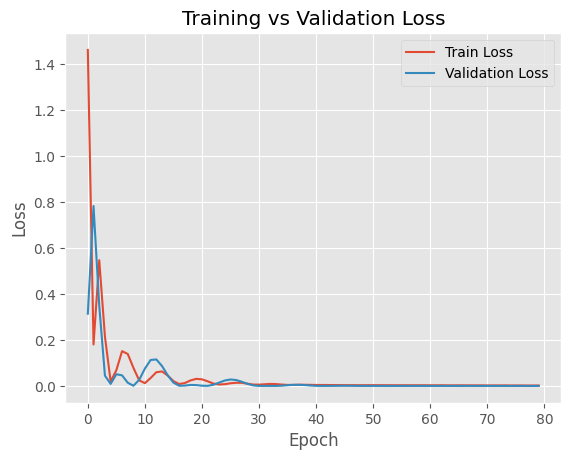

In [31]:
train_losses, val_losses = train_model(
    model, X_train, y_train, X_val, y_val, loss_fn, optimizer,epochs=80 
)


RMSE: 0.7217
MAE : 0.5000
MAPE: 1.2196%
R²  : 0.9717


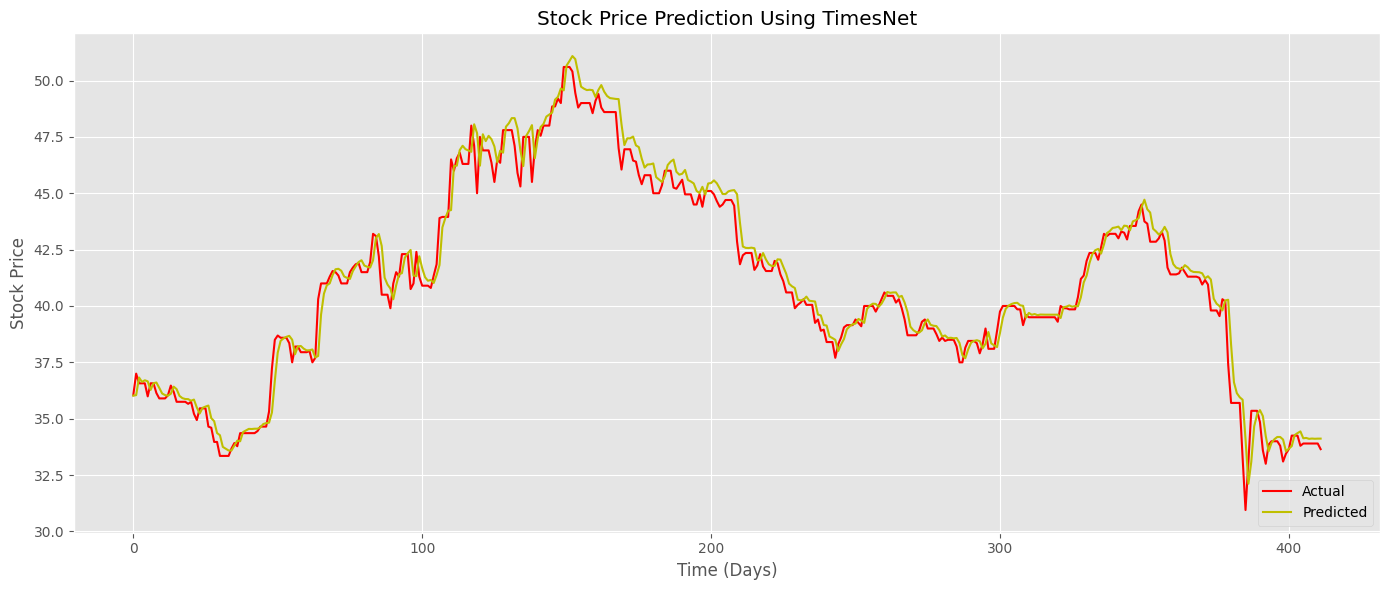

In [32]:
def evaluate(preds, actuals):

    pred_flat = preds.flatten()
    actual_flat = actuals.flatten()

    rmse = mean_squared_error(actual_flat, pred_flat, squared=False)
    mae = mean_absolute_error(actual_flat, pred_flat)
    mape = np.mean(np.abs((actual_flat - pred_flat) / actual_flat)) * 100
    r2 = r2_score(actual_flat, pred_flat)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.4f}%")
    print(f"R²  : {r2:.4f}")
    
model.eval()
with torch.no_grad():
    # Giả sử model output và y_test chỉ là cột 'close'
    preds = model(X_test.to(device)).cpu().numpy()
    actuals = y_test.cpu().numpy()

    # Reshape về (n_samples, 1)
    preds = preds.reshape(-1, 1)
    actuals = actuals.reshape(-1, 1)

    # Vị trí cột 'close' trong scaler
    close_idx = ['close'].index('close')

    # # Tạo dummy array với 4 cột để đảo chuẩn hóa
    # dummy_preds = np.zeros((preds.shape[0], 2))
    # dummy_preds[:, close_idx] = preds.flatten()

    # dummy_actuals = np.zeros((actuals.shape[0], 2))
    # dummy_actuals[:, close_idx] = actuals.flatten()
    # Vì chỉ có 1 cột 'close', scaler chỉ fit trên 1 cột
    dummy_preds = preds.flatten().reshape(-1, 1)
    dummy_actuals = actuals.flatten().reshape(-1, 1)

    preds_original = np.exp(scaler.inverse_transform(dummy_preds)[:, 0])
    actuals_original = np.exp(scaler.inverse_transform(dummy_actuals)[:, 0])

    # # Đảo chuẩn hóa
    # preds_original = np.exp(scaler.inverse_transform(dummy_preds)[:, close_idx])
    # actuals_original = np.exp(scaler.inverse_transform(dummy_actuals)[:, close_idx])

    # Đánh giá
    evaluate(preds_original, actuals_original)
def plot_data(y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, c='r', label='Actual')        # Giá trị thực tế (giá close thật)
    plt.plot(y_pred, c='y', label='Predicted')     # Giá trị dự đoán (giá close dự đoán)
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.title("Stock Price Prediction Using TimesNet")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_data(actuals_original, preds_original)

Mô hình kết hợp TimesNet + Sentiment Analysis

In [33]:

seq_len = 30
pred_len = 1
# Tải dữ liệu và tiền xử lý
data = pd.read_csv('sentiment_score.csv')
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data = data[['close', 'sentiment_sector', 'sentiment_direct_PLX']]
data['close'] = np.log(data['close'])
# data['volume'] = np.log(data['volume'] + 1)  
data['sentiment_sector'] = data['sentiment_sector']
data['sentiment_direct_PLX'] = data['sentiment_direct_PLX']
data.fillna(0, inplace=True) 
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
data[['close', 'sentiment_sector', 'sentiment_direct_PLX']] = scaler.fit_transform(data[['close', 'sentiment_sector', 'sentiment_direct_PLX']])

# Chia dữ liệu thành train, val, test (80% train, 10% validation, 10% test)
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)
test_size = len(data) - train_size - val_size

train = data.iloc[:train_size]
val = data.iloc[train_size:train_size + val_size]
test = data.iloc[train_size + val_size:]

# Hàm tạo sequences
def create_sequences(data, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data) - seq_len - pred_len + 1):
        X.append(data.iloc[i:i+seq_len].values)  
        y.append(data.iloc[i+seq_len:i+seq_len+pred_len, 0])  
    return np.array(X), np.array(y)

# Tạo sequences cho các tập train, val, test
X_train, y_train = create_sequences(train, seq_len, pred_len)
X_val, y_val = create_sequences(val, seq_len, pred_len)
X_test, y_test = create_sequences(test, seq_len, pred_len)
# Convert dữ liệu sang tensor và thêm chiều cuối cho phù hợp với output model
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

# In ra kích thước của các tập dữ liệu
print(f"Train: {X_train.shape}, {y_train.shape}")
print(f"Val: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")


Train: torch.Size([2025, 30, 3]), torch.Size([2025, 1, 1])
Val: torch.Size([410, 30, 3]), torch.Size([410, 1, 1])
Test: torch.Size([412, 30, 3]), torch.Size([412, 1, 1])


In [34]:
train

,close,sentiment_sector,sentiment_direct_PLX
Date,,,
2017-04-21,0.375713,0.501596,0.791504
2017-04-22,0.375713,0.501596,0.857696
2017-04-23,0.375713,0.501596,0.548924
2017-04-24,0.366469,0.501596,0.499945
2017-04-25,0.303680,0.501596,0.753645
...,...,...,...
2022-12-01,0.207107,0.501596,0.499945
2022-12-02,0.219948,0.501596,0.499945
2022-12-03,0.219948,0.928362,0.499945


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "input_dim": X_train.shape[2],
    "hidden_dim": 96,
    "pred_len": pred_len,
    "output_dim": 1,
    "n_blocks": 3,
    "kernel_size": 3,
    "dropout": 0.2,
}

model = TimesNet(config).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam( model.parameters(), lr=0.001, weight_decay=1e-5)



Epoch 1/80 - Train Loss: 0.5311 - Val Loss: 0.6180
Epoch 2/80 - Train Loss: 0.4291 - Val Loss: 0.3774
Epoch 3/80 - Train Loss: 0.2505 - Val Loss: 0.0510
Epoch 4/80 - Train Loss: 0.0271 - Val Loss: 0.0150
Epoch 5/80 - Train Loss: 0.0469 - Val Loss: 0.0666
Epoch 6/80 - Train Loss: 0.1139 - Val Loss: 0.0680
Epoch 7/80 - Train Loss: 0.1130 - Val Loss: 0.0315
Epoch 8/80 - Train Loss: 0.0643 - Val Loss: 0.0054
Epoch 9/80 - Train Loss: 0.0221 - Val Loss: 0.0134
Epoch 10/80 - Train Loss: 0.0103 - Val Loss: 0.0457
Epoch 11/80 - Train Loss: 0.0258 - Val Loss: 0.0740
Epoch 12/80 - Train Loss: 0.0439 - Val Loss: 0.0788
Epoch 13/80 - Train Loss: 0.0482 - Val Loss: 0.0608
Epoch 14/80 - Train Loss: 0.0362 - Val Loss: 0.0340
Epoch 15/80 - Train Loss: 0.0191 - Val Loss: 0.0128
Epoch 16/80 - Train Loss: 0.0088 - Val Loss: 0.0041
Epoch 17/80 - Train Loss: 0.0092 - Val Loss: 0.0049
Epoch 18/80 - Train Loss: 0.0162 - Val Loss: 0.0087
Epoch 19/80 - Train Loss: 0.0221 - Val Loss: 0.0104
Epoch 20/80 - Train L

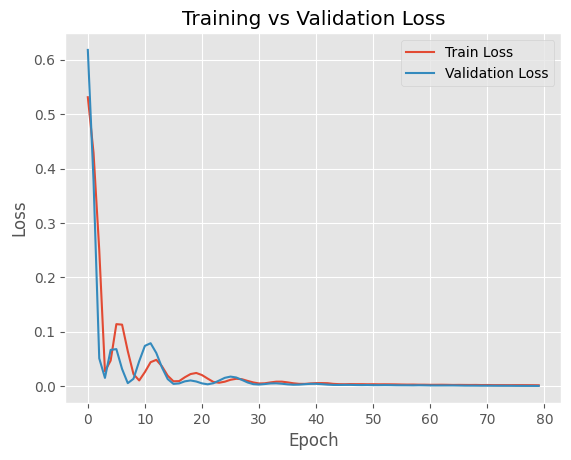

In [36]:
train_losses, val_losses = train_model(
    model, X_train, y_train, X_val, y_val, loss_fn, optimizer,epochs=80
)


In [37]:
def evaluate(preds, actuals):

    pred_flat = preds.flatten()
    actual_flat = actuals.flatten()

    rmse = mean_squared_error(actual_flat, pred_flat, squared=False)
    mae = mean_absolute_error(actual_flat, pred_flat)
    mape = mean_absolute_percentage_error(actual_flat, pred_flat)
    r2 = r2_score(actual_flat, pred_flat)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"R²  : {r2:.4f}")
    
model.eval()
with torch.no_grad():
    # Giả sử model output và y_test chỉ là cột 'close'
    preds = model(X_test.to(device)).cpu().numpy()
    actuals = y_test.cpu().numpy()

    # Reshape về (n_samples, 1)
    preds = preds.reshape(-1, 1)
    actuals = actuals.reshape(-1, 1)

    # Vị trí cột 'close' trong scaler
    close_idx = ['close', 'sentiment_score', 'sentiment_score_PLX'].index('close')

    # Tạo dummy array với 4 cột để đảo chuẩn hóa
    dummy_preds = np.zeros((preds.shape[0], 3))
    dummy_preds[:, close_idx] = preds.flatten()

    dummy_actuals = np.zeros((actuals.shape[0], 3))
    dummy_actuals[:, close_idx] = actuals.flatten()

    # Đảo chuẩn hóa
    preds_original = np.exp(scaler.inverse_transform(dummy_preds)[:, close_idx])
    actuals_original = np.exp(scaler.inverse_transform(dummy_actuals)[:, close_idx])

    # Đánh giá
    evaluate(preds_original, actuals_original)


RMSE: 0.8929
MAE : 0.5285
MAPE: 0.0128
R²  : 0.9566


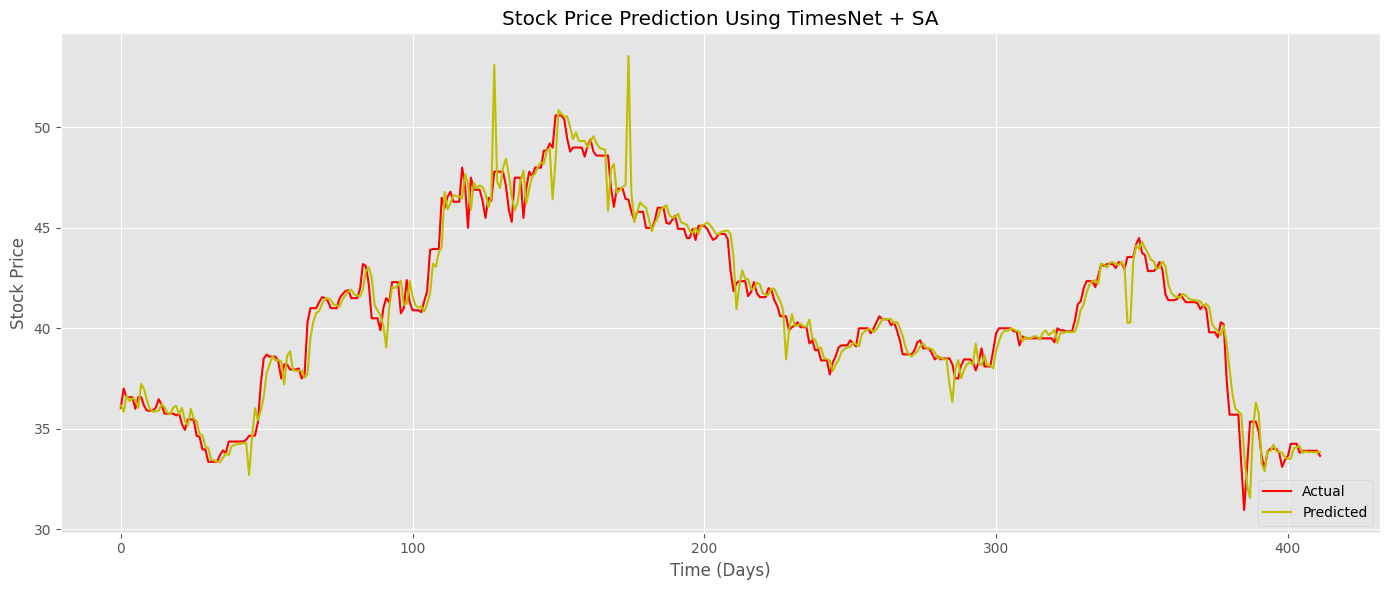

In [38]:
def plot_data(y_true, y_pred):
    plt.figure(figsize=(14, 6))
    plt.plot(y_true, c='r', label='Actual')        # Giá trị thực tế (giá close thật)
    plt.plot(y_pred, c='y', label='Predicted')     # Giá trị dự đoán (giá close dự đoán)
    plt.xlabel('Time (Days)')
    plt.ylabel('Stock Price')
    plt.title("Stock Price Prediction Using TimesNet + SA")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_data(actuals_original, preds_original)

ARIMA

In [39]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [40]:
stock_data = pd.read_csv('sentiment_score.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
df_close = stock_data['close']

In [41]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2937 entries, 0 to 2936
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  2937 non-null   datetime64[ns]
 1   close                 2937 non-null   float64       
 2   volume                2937 non-null   float64       
 3   sentiment_sector      2937 non-null   float64       
 4   sentiment_direct_PLX  2937 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 114.9 KB


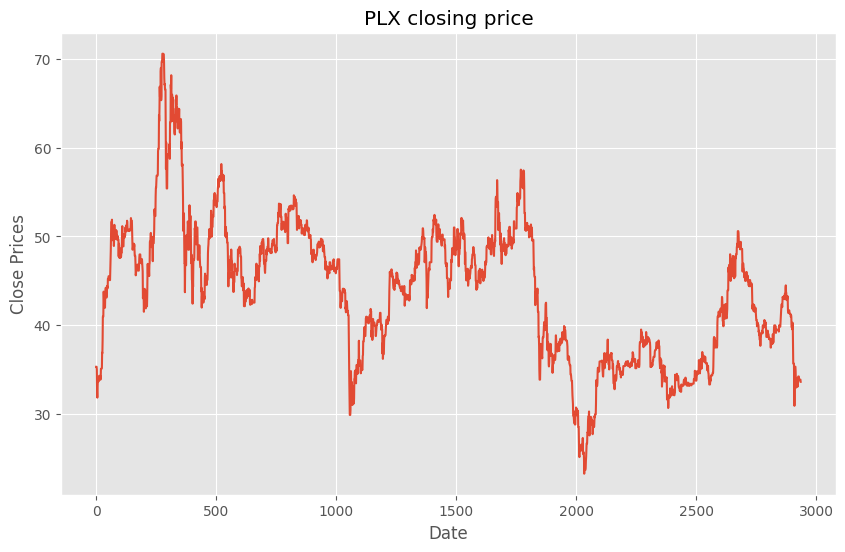

In [42]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['close'])
plt.title('PLX closing price')
plt.show()

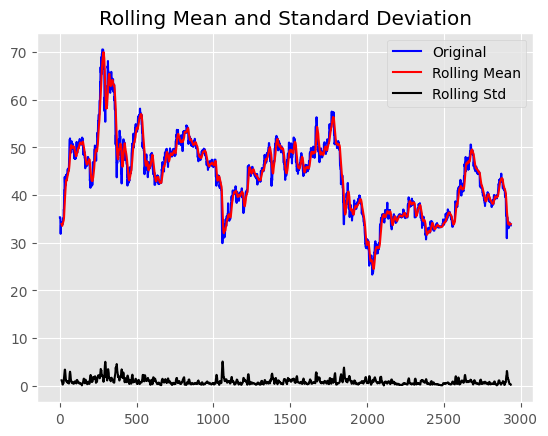

Results of dickey fuller test
Test Statistics                  -2.467372
p-value                           0.123616
No. of lags used                 28.000000
Number of observations used    2908.000000
critical value (1%)              -3.432601
critical value (5%)              -2.862534
critical value (10%)             -2.567299
dtype: float64


In [43]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

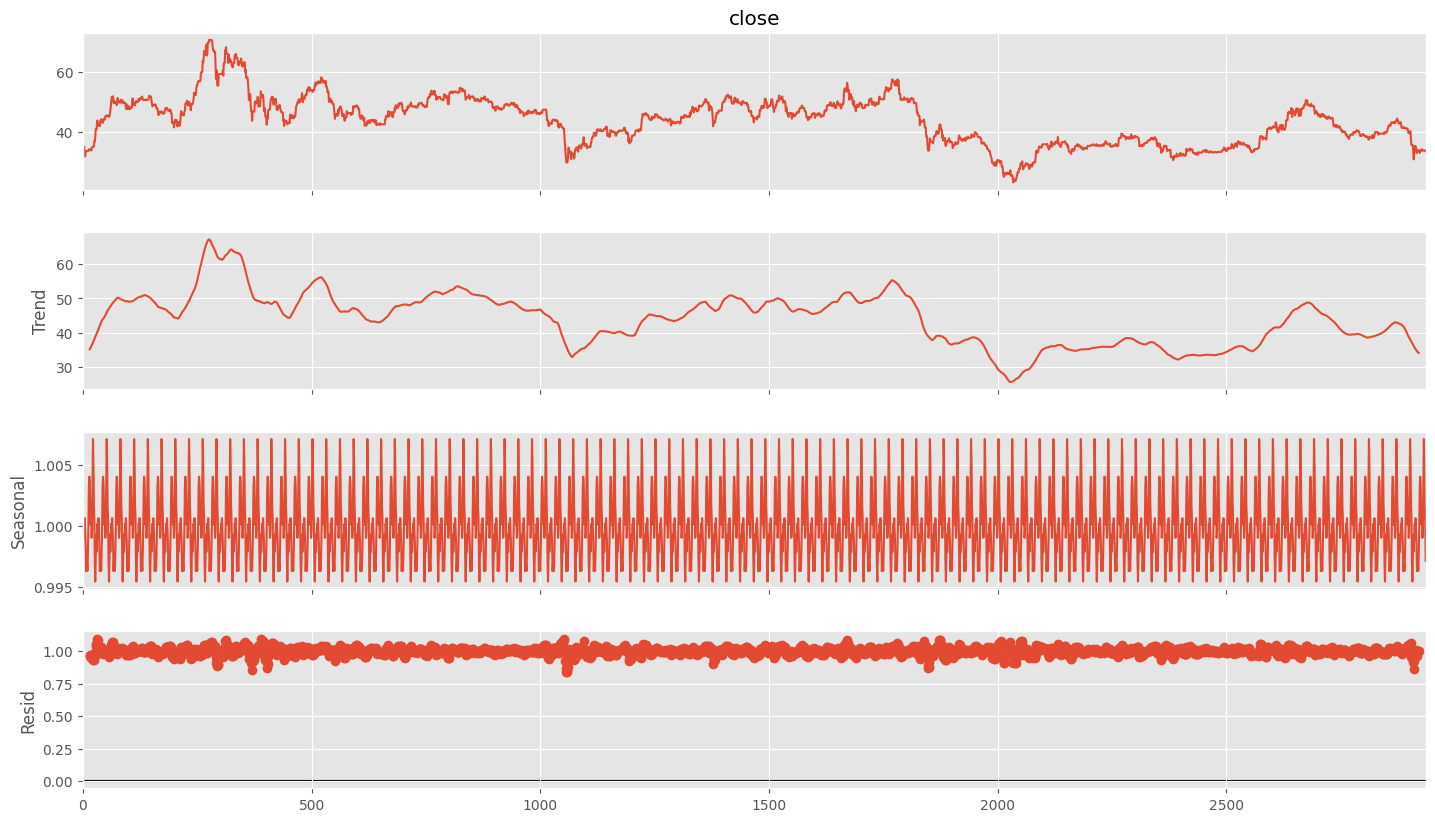

In [44]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period= 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

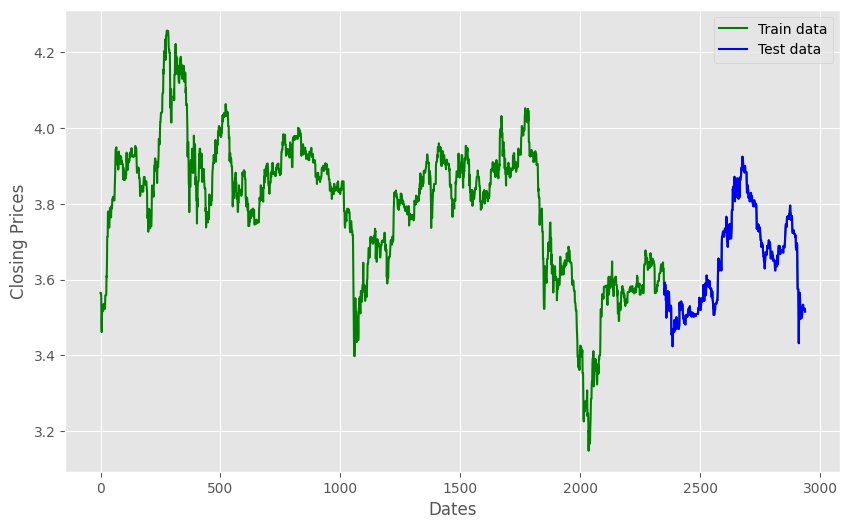

In [45]:
df_log = np.log(df_close)
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [46]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12923.130, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12240.662, Time=0.72 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.10 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12238.353, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6624.409, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-12236.261, Time=0.44 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12250.009, Time=0.66 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4355.596, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12255.686, Time=1.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-12247.63

In [47]:
model = ARIMA(train_data, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2346
Model:                 ARIMA(2, 0, 1)   Log Likelihood                6131.161
Date:                Thu, 29 May 2025   AIC                         -12252.323
Time:                        21:17:25   BIC                         -12223.520
Sample:                             0   HQIC                        -12241.832
                               - 2346                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7591      0.062     60.247      0.000       3.637       3.881
ar.L1          0.2488      0.150      1.663      0.096      -0.044       0.542
ar.L2          0.7417      0.149      4.990      0.0

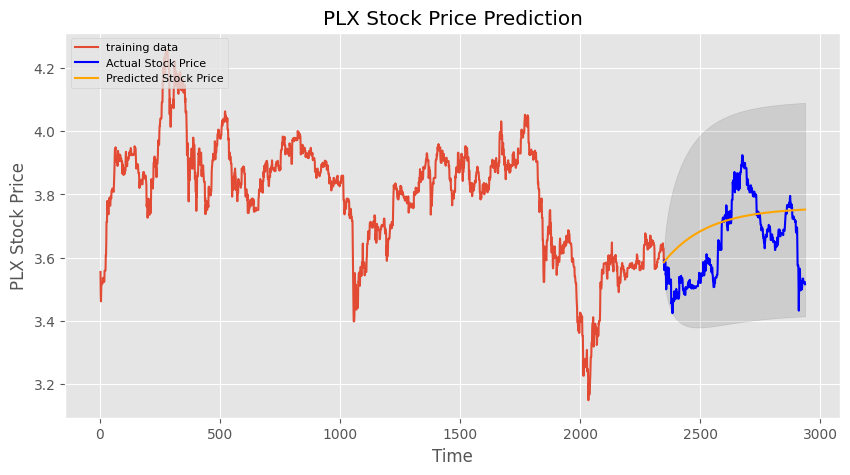

In [48]:
# Forecast with confidence intervals
n_periods = len(test_data)
forecast_res = fitted.get_forecast(steps=n_periods)
fc = forecast_res.predicted_mean
conf = forecast_res.conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('PLX Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PLX Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [49]:
# report performance
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: '+str(mse))
mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))

MSE: 20.77128805970164
MAE: 3.930591643579878
RMSE: 4.557552858684322
MAPE: 0.10580882611116245


ARIMAX

In [50]:
df_sentiment = stock_data[['sentiment_direct_PLX','sentiment_sector']].shift(1)
df_sentiment.fillna(0, inplace=True)
n = int(len(df_log)*0.8)
train_y, test_y = df_log[:n], df_log[n:]
train_exog, test_exog = df_sentiment[:n], df_sentiment[n:]

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12939.294, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12258.986, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12230.805, Time=0.48 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-12257.298, Time=0.78 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=6632.507, Time=0.24 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.96 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-12268.524, Time=0.20 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-4358.935, Time=0.37 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-12272.188, Time=0.52 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-12265.93

c:\Users\LAP\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


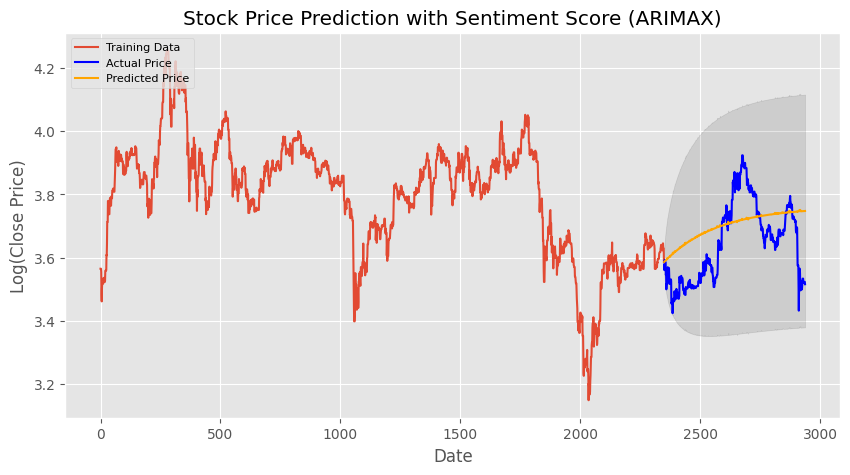

MSE: 19.722505396187692
MAE: 3.8138993198324065
RMSE: 4.441002746698959
MAPE: 0.10196205041259429


In [51]:
model_autoARIMAX = auto_arima(train_y,
                              exogenous=train_exog,
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              d=None, test='adf',
                              seasonal=False,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(model_autoARIMAX.summary())

# Lấy thông số order từ auto_arima
p, d, q = model_autoARIMAX.order

# Huấn luyện mô hình ARIMAX
model = ARIMA(train_y, order=(p,d,q), exog=train_exog)
fitted = model.fit()
print(fitted.summary())

# Dự báo trên tập test
forecast_res = fitted.get_forecast(steps=len(test_y), exog=test_exog)
fc = forecast_res.predicted_mean
conf = forecast_res.conf_int(alpha=0.05)

# Series kết quả
fc_series = pd.Series(fc, index=test_y.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_y.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_y.index)

# Vẽ biểu đồ
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_y, label='Training Data')
plt.plot(test_y, color='blue', label='Actual Price')
plt.plot(fc_series, color='orange', label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('Stock Price Prediction with Sentiment Score (ARIMAX)')
plt.xlabel('Date')
plt.ylabel('Log(Close Price)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Đánh giá mô hình (chuyển về scale gốc)
actual = np.exp(test_y)
predicted = np.exp(fc)

mse = mean_squared_error(actual, predicted)
mae = mean_absolute_error(actual, predicted)
rmse = math.sqrt(mse)
mape = np.mean(np.abs(predicted - actual)/np.abs(actual))

print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)